In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import random

from PIL import Image
from skimage.segmentation import felzenszwalb
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

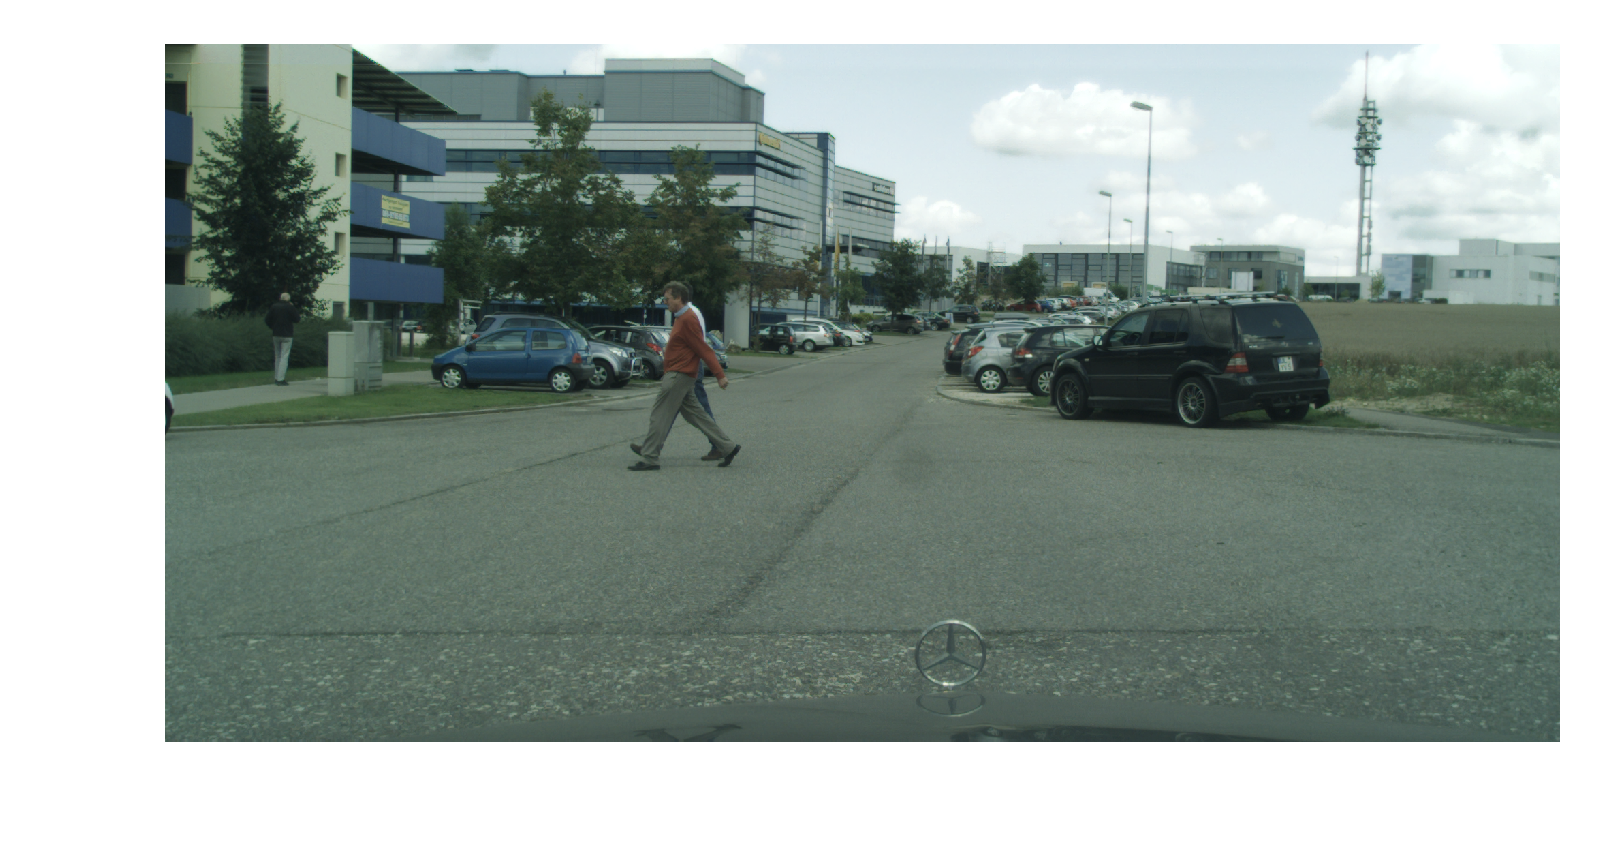

In [14]:
img_fn = '/mnt/vol04/datasets/cityscapes/leftImg8bit/train/ulm/ulm_000087_000019_leftImg8bit.png'
img = np.array(Image.open(img_fn), dtype=np.float) / 255.
superpixels = felzenszwalb(img, scale=300.0)
# superpixels = slic(img, 1000)

img_fn = '/mnt/vol04/shunta/codes/road-segm/results/paper/ulm_000087_000019_leftImg8bit_bright.png'
img = np.array(Image.open(img_fn), dtype=np.float) / 255.

plt.clf()
fig, ax = plt.subplots(dpi=300)
ax.axis('off')
ax.imshow(img, interpolation='nearest', aspect='equal')
plt.show()

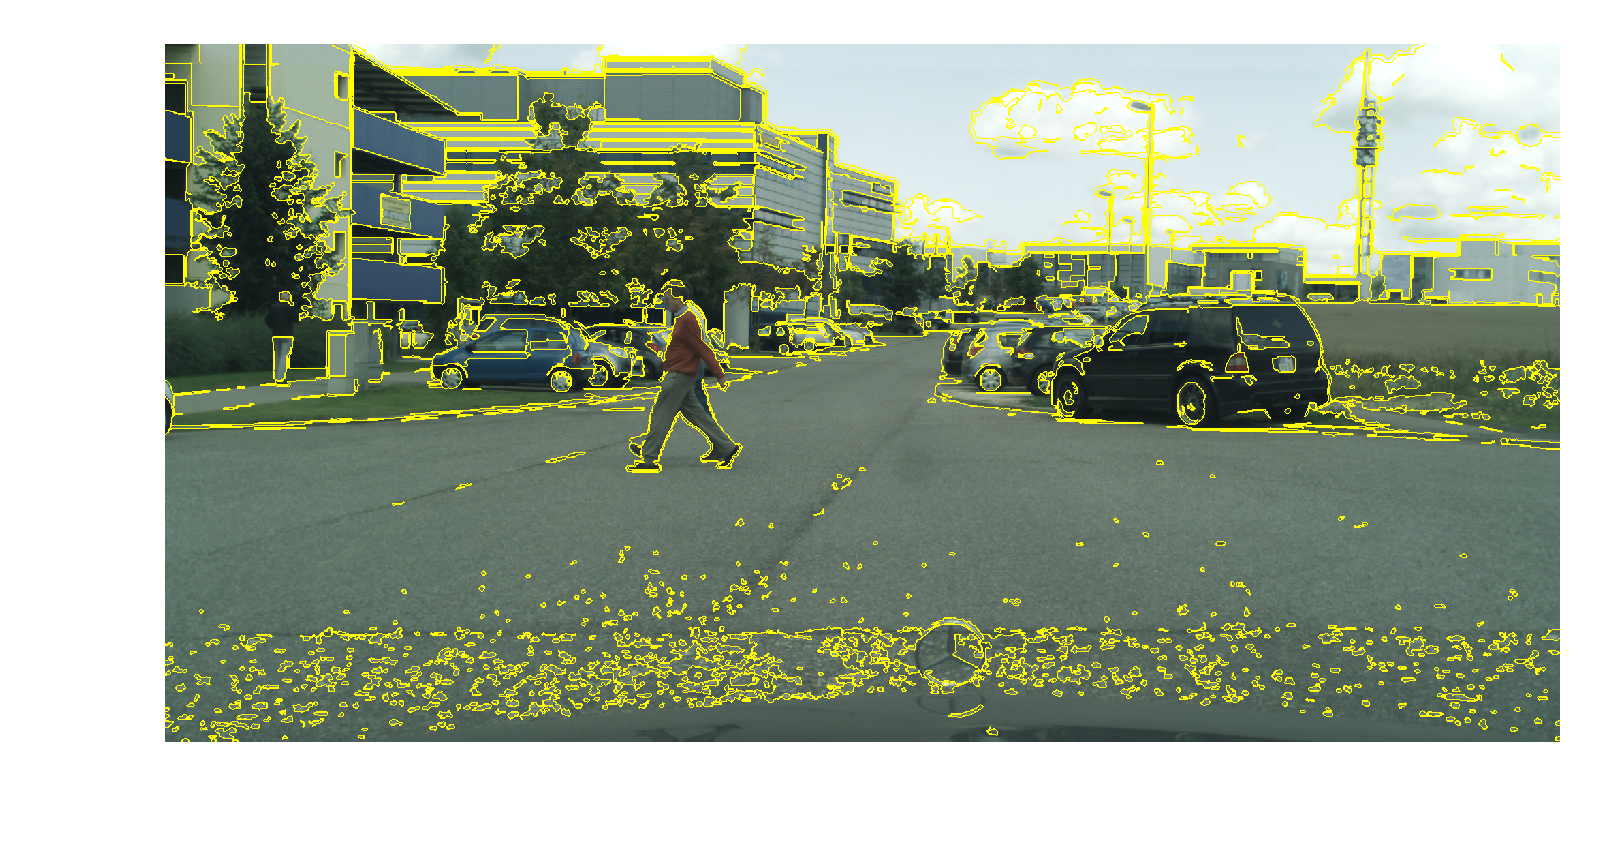

In [15]:
plt.clf()
fig, ax = plt.subplots(dpi=300)
ax.axis('off')
ax.imshow(mark_boundaries(img, superpixels))
plt.show()

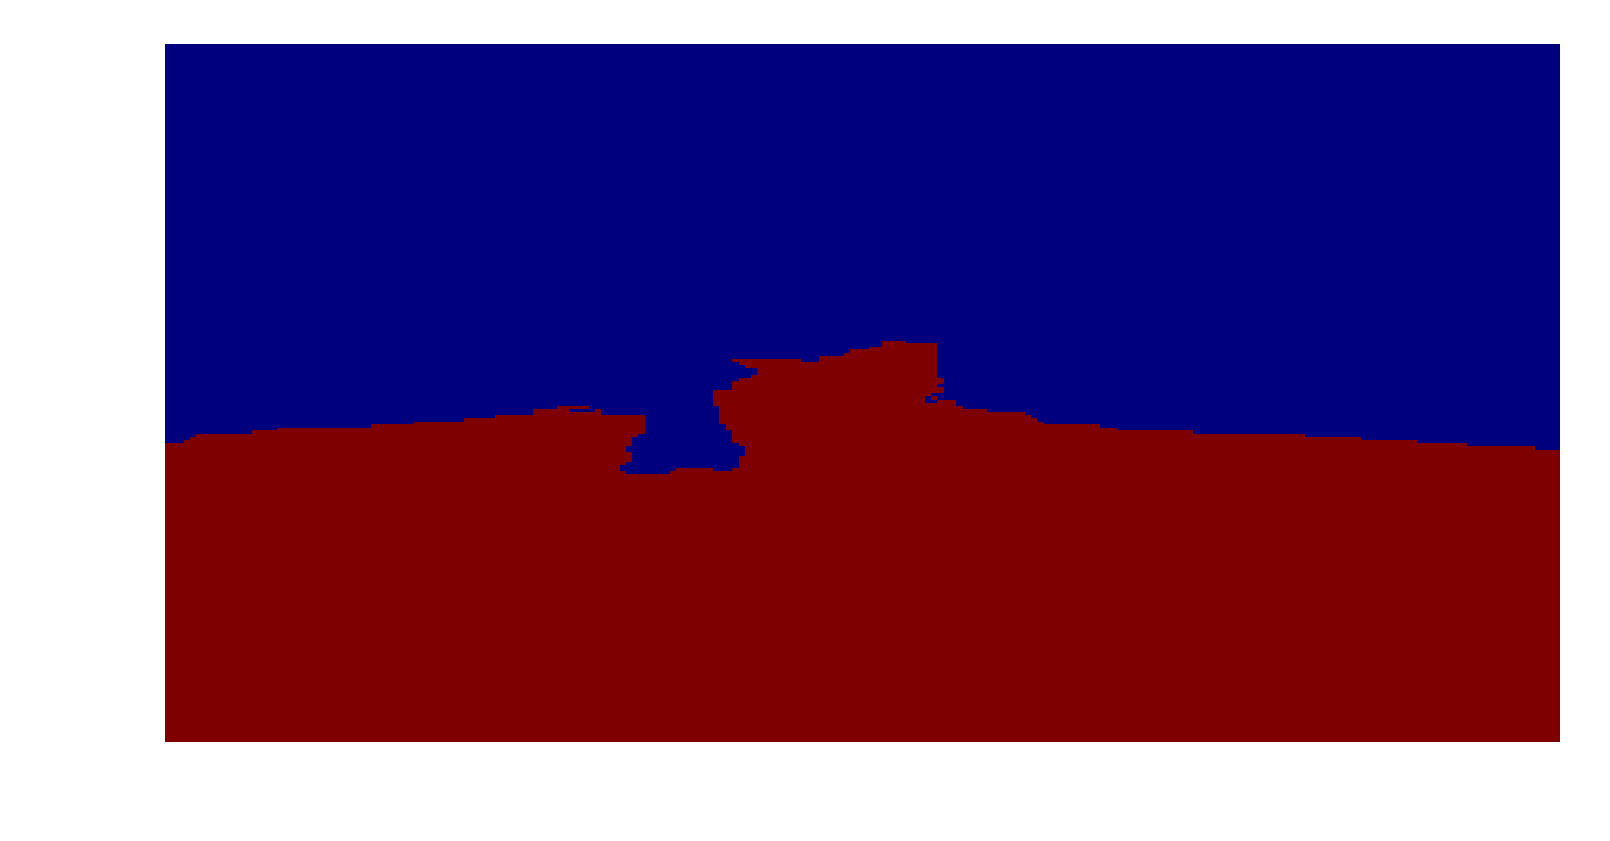

In [19]:
mask_fn = '/mnt/vol04/shunta/codes/road-segm/results/estimated_train_labels_4-300-30_no-horizon/ulm_000087_000019_leftImg8bit.npy'
mask = np.load(mask_fn)

plt.clf()
fig, ax = plt.subplots(dpi=300)
ax.axis('off')
# ax.imshow(img)
ax.imshow(mask, cmap=plt.cm.jet, interpolation='none')
plt.show()

# plt.clf()
# fig, ax = plt.subplots(dpi=300)
# ax.axis('off')
# ax.imshow(superpixels)
# plt.show()

(1024, 2048)


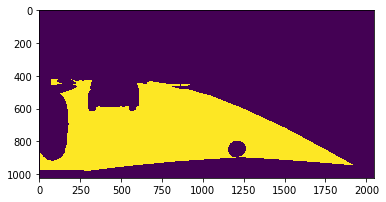

In [134]:
label = np.load('../data/val_road_void_gt/frankfurt_000000_013067_leftImg8bit.png.npz')
label = label['arr_0']
print(label.shape)
plt.imshow(label == 1)

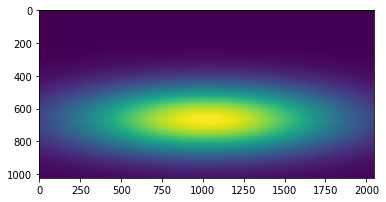

In [141]:
y_rel_pos = 0.65
x_rel_pos = 0.5
y_rel_sigma = 0.1
x_rel_sigma = 0.2
h, w = superpixels.shape
xcoord, ycoord = np.meshgrid(np.arange(w), np.arange(h))

ymean, xmean = int(h * y_rel_pos), int(w * x_rel_pos)
y_sigma = h * y_rel_sigma
x_sigma = w * x_rel_sigma

weights = np.exp(
    -((ycoord - ymean) ** 2 / (2 * y_sigma) ** 2
      + (xcoord - xmean) ** 2 / (2 * x_sigma) ** 2))

plt.imshow(weights)
plt.show()

In [2]:
n_select = 10
n_neighbor = 4
img_h = img.shape[0]
feature_map_h = 128
feature_map_w = 256
feature_ratio = feature_map_h / img_h

feature_map = np.random.rand(1, 1024, feature_map_h, feature_map_w)

yy, xx = np.meshgrid(np.arange(feature_map_h), np.arange(feature_map_w))
ft_coords = np.stack([yy, xx]).transpose(1, 2, 0) + 0.5

plt.scatter(ft_coords.reshape(-1, 2)[:, 0], ft_coords.reshape(-1, 2)[:, 1])
plt.show()

for idx in np.unique(superpixels):
    y, x = np.where(superpixels == idx)
    coords = list(zip(y.tolist(), x.tolist()))
    random.shuffle(coords)
    selected_points = np.asarray(coords[:n_select]) * feature_ratio + 0.5
    
    features_in_sp = []
    for p in selected_points:
        flat_ft_coords = ft_coords.reshape(-1, 2)
        dist = np.sqrt((flat_ft_coords - p) ** 2).sum(axis=1)
        idx = np.argsort(dist)[:n_neighbor]
        neighbor_ft_coords = flat_ft_coords[idx] - 0.5
        max_y, max_x = np.max(neighbor_ft_coords, axis=0)
        min_y, min_x = np.min(neighbor_ft_coords, axis=0)
        py, px = p

        # Bilinear interpolation
        f11 = feature_map[0, :, int(min_y), int(min_x)]
        f12 = feature_map[0, :, int(max_y), int(min_x)]
        f21 = feature_map[0, :, int(min_y), int(max_x)]
        f22 = feature_map[0, :, int(max_y), int(max_x)]
        
        fp = (max_x - px) * (max_y - py) * f11
        fp += (max_x - px) * (py - min_y) * f12
        fp += (px - min_x) * (max_y - py) * f21
        fp += (px - min_x) * (py - min_y) * f22
        fp = 1. / ((max_x - min_x) * (max_y - min_y)) * fp
        features_in_sp.append(fp)
    features_in_sp = np.asarray(features_in_sp)
    
    superpixel_feature = np.mean(features_in_sp, axis=0)
    print(superpixel_feature.shape)
    break

NameError: name 'img' is not defined